**TODO**
- clearfy language

# Getting started with Python & SPICE, DC Operating Point Analysis

In [1]:
#%%writefile DC_1_Codes.py
#Library import statements

from skidl.pyspice import *
#can you say cheeky 
import PySpice as pspice
#becouse it's written by a kiwi you know
import lcapy as kiwi

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import YouTubeVideo, display

import traceback
import warnings

In [2]:
#notebook specific loading control statements 
%matplotlib inline
#tool to log notebook internals
#https://github.com/jrjohansson/version_information
%load_ext version_information
%version_information skidl, PySpice,lcapy, sympy, numpy, matplotlib, pandas, scipy

Software,Version
Python,3.7.6 64bit [GCC 7.3.0]
IPython,7.12.0
OS,Linux 4.19.104 microsoft standard x86_64 with debian bullseye sid
skidl,0.0.31.dev0
PySpice,1.4.3
lcapy,0.75.dev0
sympy,1.6.2
numpy,1.18.1
matplotlib,3.3.0
pandas,1.1.4


#Starting simple with the basic three¶
By the basic three, I mean the `Linear Independent Voltage Sources`, `Linear Independent Current Sources`, and `Resistors` as the three elements to start building primitive circuits. So what is an element, it's SPICE terminology for any device or part that affects the voltage and or current in the circuit. To start with the only elements we are using in this section are Ideal Voltage Souces, Ideal Current Source, and ideal resistors. SPICE allows us to have some fairly fancy elements like semiconductor resistors, but let's stick to the basics here.
The other part of any circuit is interconnections between the elements where these in SPICE (99% of the time) are idealized zero loss wires, or in SPICE terminally nets. Where a net also represents a node in our circuit. SO to start we will look a the well-known relation between resistors and our independent sources as given by Ohms law. Where for the analytical explanation see All About Electronics YT video on "Ohm's Law"


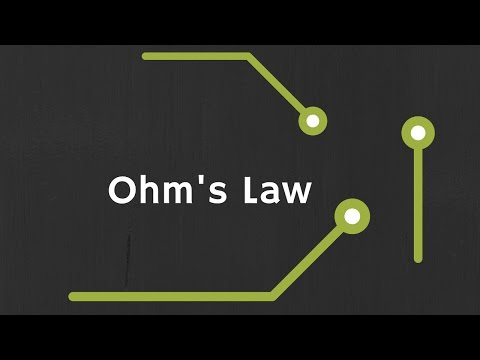

In [3]:
YouTubeVideo('PV8CMZZKrB4', width=500, height=400)

Again the purpose of the work isn't to go over the analytical paper and pencil work, but in part show how to use Python & SPICE to verify our results and go further with SPICE circuit simulation enhanced by being wrapping as much as we can in Python. And so we start our first foray by verifying the results of the example circuit at the ~10:30 mark of All ABOUT ELELCTRONINCS YT video on "Ohm's Law", a simple voltage source, and resistor. 

## Building a circuit to produce a SPICE netlist with SKiDl¶
The first thing to understand is that we are building a global circuit here. SKiDl also has local circuits where all of the circuit is contained to an object. And we will work with those eventually but for now, we will work with the global circuit. Where the global circuit will automatically append to its self any SKiDl elements instantiate between calls of `reset()`. Therefore, we have to call `reset()` to clear out the global circuit to a blank slate before adding to it.
Secondly, let's delve into the three things that all SPICE netlist must-have.

1.	Elements: these are the things that manipulate the electricity in a circuit

2.	Nets: nets are the same things as a single node, which is the same thing as idle traces or wires in a circuit. They direct the flow of electricity to and from the elements. In SPICE (till you get into layout) a net is an ideal connection between element terminals with a common voltage

3.	A master ground net: This is a net that has zero voltage that SPICE references all other voltages from. While there are many types of grounds especially important in more complex and mixed-signal circuits SPICE is only concerned with a universal ground designated as 0


In [4]:
#clear global SkiDl circuit
reset()
#create one of two nets, gnd we get for free
net_1=Net('N1')

#create a voltage source and set it's dc value
vs=V(dc_value=10@u_V)
#connect the voltage source to the nets
vs['p', 'n']+=net_1, gnd

#create the resistor and set its value to the analytically found value
r1=R(value=5@u_Ohm)
#cpnnect the resistor to the nets
r1[1, 2]+=net_1, gnd

#generate the netlist and print it
circ=generate_netlist()
print(circ)

.title 
R1 N1 0 5Ohm
V1 N1 0 10V




No errors or warnings found during netlist generation.



So what did we do to get the netlist and what does the netlist mean.

In line 2 we called `reset()` this clears or resets, the global SKiDl netlist so that no previous elements or connections exist such that we have a blank slate. 

In line 4 a single net was created since this circuit only has two nodes or wires. Where one of those wires is at ground where we get for free with `gnd` which is the common name for the master ground

In line 5 a voltage source is created. Pure DC voltage sources are created in SkiDl with `V()` but as will be shown when we get to AC circuits DC voltage sources are a subset of the global use of a linear independent voltage source in SPICE. Further, we set the Voltage source to a python object `vs`. We do this for two reasons. 
 1. since everything is an object in python we can call and manipulate information about our voltage source `vs` using its variable name
 2. we need to be able to set it's connections to the circuit

In line 9 we connect the voltage source to our two nets, and again we get ground for free with `gnd` also since a voltage source is a directional element we need to tell it what connection (terminal) is connected to what net with the access call to `vs`: `['p', 'n']`
where `'p'` is the positive terminal and `'n'` is the negative one. 

In line 12 we create the resistor in the same way as the voltage source back on line 7 with the only difference being that the resistance of a resistor is universal to DC and AC so it's argument is `value` and since 99% of the resistors in the world are omnidirectional we connect it to the nets in line 14  using an access call of just 1 & 2 to tell what terminals are connected to what nets without regard to polarity. 

In line 17 we create the netlist and set it to the object `circ` the reason being is that we want to print out our netlist for debugging and again it's an object so there is information in it we want to utilize. But we also have to because `circ` is not only an object with a netlist string it is a full circuit object that will be passed to the simulator shortly

So what does the netlist say:
```
.title
```
this is just the name of the circuit where we are ignoring right now

```
R1 N1 0 5Ohm
```
This says that the circuit has an element `R1`. Where the first letter `R` tells SPICE it's a resistor and `1` its designator. The rest of the statement says that it's terminals are connected to  net `N1` and net `0`, ground, with a resistance of `5Ohm`

And the last line 
```
V1 N1 0 10V
```
says we have Indepened Voltage source `V1` where again the first letter `V` tells SPICE it's an independent voltage source and its designator `1` with its positive terminal connected to net `N1` and negative terminal `0` connected to ground with a DC value of `10V`


# SPICE's DC Operating Point simulation `.op` 

This is the simplest of all simulations since it just produces results with everything being static. Now technically there is a .dc simulation that is coming up in this chapter  that gives the same results when set up a certain way. But that's to come. And when using .dc simulation a series of operating point simulations are just being carried out in the background anyway. So let get in the habit of if we just need static value for a dc simulation we use operating point analysis.  

Also, what is the deal between AC and DC simulations? The main difference is that a DC simulation will ignore capacitors and inductors as opens and shorts respectively not only for true capacitor and inductor elements in the circuit but also all internal capacitors and inductors as part of an elements internal model.

In [5]:
#create a simulation obj from our circuit
sim=circ.simulator()
#perform the .op simulation and store results to new obj
dc_vals=sim.operating_point()

So we have a simulation object made by `sim=circ.simulator()` where this creates a simulation environment of the circuit netlist stored in `circ` that is set to `sim`. When the simulation is created it is at default 25C. From there we can then call a simulation type to run on the circuit stored in  `sim` given that all the appropriate elements and connections are there to work with the simulation to get results that make sense. At the moment we're sticking with the very basics by doing an operating point analysis via `dc_vals=sim.operating_point()` where `dc_vals` stores the result of the operating point analysis that was called with the`.operating_point()` method call. So to get our results we need to look at the first two things that are in `dc_vals` 

In [6]:
#nodes
print(f'dc_vals Nodes: {dc_vals.nodes}')

#branches
print(f'dc_vals Branches: {dc_vals.nodes}')

dc_vals Nodes: {'n1': WaveForm n1 [10.]@V}
dc_vals Branches: {'n1': WaveForm n1 [10.]@V}


We will see that there are more things that a simulation can return but that is coming. The import results that most SPICE simulations store all the branch and node values. Where those values are stored in a dictionary inside `dc_vals`. Where simulation returns have a nice super dictionary of values to quickly retrieve results from and treat as NumPy arrays. But the supper dictionary is primarily a construct of the branch and node value results of the simulation as is shown in the cell above. If you need a reference on circuit terminally conventions, please watch the following video from ALL ABOUT ELECTRONICS  "Circuit terminology: Concept of Loop, Mesh, Node and Branch explained"

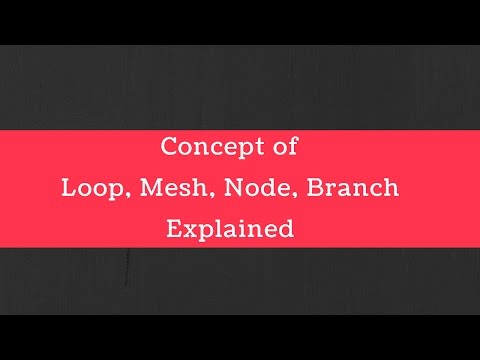

In [7]:
YouTubeVideo('zUGaU4kZpag', width=500, height=400)

To use the supper dictionary lookup of the results from a simulation we have to input the exact NETLIST name of the source or node as shown

In [8]:
# Get voltage at the node
dc_vals['N1']

WaveForm n1 [10.]@V

but this is tedious and since we have to look back at the netlist so instead we can take advantage of Python to automate this and put our results in a convenient table with SKiDl's help

In [9]:
for n in circ.node_names:
    try:
        print(f"Node {n} :{dc_vals[n]}")
    
    except Exception as e:
        print(f"got an error when trying to retrive node voltage {n} \nwith the following  error: \n")
        print(traceback.format_exc())

got an error when trying to retrive node voltage 0 
with the following  error: 

Traceback (most recent call last):
  File "/home/iridium/anaconda3/lib/python3.7/site-packages/PySpice/Probe/WaveForm.py", line 294, in __getitem__
    return self._get_item(name)
  File "/home/iridium/anaconda3/lib/python3.7/site-packages/PySpice/Probe/WaveForm.py", line 288, in _get_item
    raise IndexError(name)
IndexError: 0

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "<ipython-input-9-528ab68a0bd1>", line 3, in <module>
    print(f"Node {n} :{dc_vals[n]}")
  File "/home/iridium/anaconda3/lib/python3.7/site-packages/PySpice/Probe/WaveForm.py", line 296, in __getitem__
    return self._get_item(name.lower())
  File "/home/iridium/anaconda3/lib/python3.7/site-packages/PySpice/Probe/WaveForm.py", line 288, in _get_item
    raise IndexError(name)
IndexError: 0

Node N1 :n1


What this means that we can't blindly use SKiDl since ngspice does not report a voltage for the ground since it is by definition always at 0V so we, therefore, need to skip it

In [10]:
for n in circ.node_names:
    #skip the ground node
    if n=='0': 
        continue
    
    print(f"Node {n} with voltage {dc_vals[n].as_ndarray()}")
    

Node N1 with voltage [10.]


We will stop here and focuses on getting the currents cause in spice getting the currents is going to be convoluted. To start there are two ways to get current in SPICE. The one that doesn't work all the time is to use internal parameters that we will address later. The surefire way is to measure the current through a voltage source. That means we can get a current measurement at a branch in our circuit for free if there is a voltage source already in that branch.

In [11]:
#not correct sign, see description below
print(f'Current at vs: {dc_vals[vs.ref].as_ndarray()} A')

Current at vs: [-2.] A


So first we took advantage of SKiDl to store the netlist name for the voltage source within the `vs` object and pass its name to our simulation results. But the current is negative with respect to our voltage sources terminal definitions. This is due to the fact that the direction of current flow is from high voltage to lower voltage. So from the circuit's point of view, the current goes from the positive terminal of the voltage source through the resistor to ground where the negative voltage of our voltage source also is. But between the two terminals of the voltage source current is flowing directly from the positive terminal to the negative one and so with the way SPICE does the accounting with supernodes the current between the terminals of a voltage source equals the opposite of the current through the supernode imposed by a voltage source

In [12]:
#correct current
print(f'Current at vs: {-dc_vals[vs.ref].as_ndarray()} A')

Current at vs: [2.] A


So if we needed to measure the current at any other branches we would have to add a voltage source that would not affect our circuit via adding a 0V source in line. This trick is known as adding a SPICE ammeter. And as will be shown further SKiDl makes adding a SPICE ammeter trivial. Opposed to having to rework schematics to add one. For our first section introducing SKiDl, PySPICE, and SPICE this is enough. In the following sections of this chapter on DC SPICE simulations, we will get familiar enough with creating circuits with SKiDl and controlling SPICE with PySPICE. So to end this section let's now introduce the power of automation SPICE with python.

## A Brief into SPICE simulation automation with Python¶¶

In the work above we manually created the circuit, the simulation object, calling an operating point simulation against the simulation object, and finally, we semi-manually sorted through operating point simulation results. We chose here to create the circuit in SKiDL instead of a schematic capture tool. Because: one for small circuits it's a lot faster, and two serves our usage of showing how to use SKiDl. And as we will come to see we can also encapsulate parts of circuits inside python functions and classes with SkiDl to then tag onto other circuits. We also manually created our circuit simulation object and then called a SPICE simulation against it. If you have never worked with any other SPICE interface before I can't stress how powerful this is to just be able to call a SPICE simulation like that. And in fact, nothing is stopping us, save the requirements of any particular SPICE simulation, from calling a myriad of SPICE simulations against the simulation object. But every time we do one of these simulations we also have to handle the data that it produces. Above we walked through how data is returned for operating point analysis and had to do a fair bit of repetitive work to get the data back in not the most presentable of manors. So let rectify that and remove that burden by creating a class to handle performing the operating point simulation, collecting the results into pandas dataframe, and spitting out at the result. For this, the result is given below, as we continue through this book we will go over the creation of these tools in what is known as abstraction. Where being able to abstract and automate the simulation and reporting will truly showcase the power of integrating SPICE with Python



In [13]:
#%%writefile -a DC_1_Codes.py

#chapter 1 section 1 op_results_collect class
#used for basic operating point simulation analysis, does not support internal parameters

class op_results_collect():
    """
    Basic class to get pyspice operating_point (ngspice `.op`) simulation results
    for simulated circuit's global elements, no internal parameters just yet, that's coming
    """
    
    def __init__(self, op_sim_circ, display_results=False):
        """
        Basic class to get pyspice operating_point (ngspice `.op`) simulation results
        for simulated circuit's global elements
        
        Args:
            op_sim_circ (pspice.Spice.Netlist.Circuit): the Netlist circuit produced 
            from SKiDl's `generate_netlist()`
            
            display_results (bool; False): option to have the simulation results
                stored in `self.results_df` automatic displayed from a jupyter notebook
                ell
        
        Returns:
            will create a simulation in `self.op_sim`, raw results of dc operating 
            point simulation will be stored in `self.op_sim_results`, the tablized
            results will be stored in pandas dataframe `self.results_df`
        
        TODO: 
            - add kwargs to the simulator
            - add an assertion that only a pyspice netlist circuit obj can
                    be passed into op_sim_circ
            
        """
        #need to add assertions for op_sim_circ ==pspice.Spice.Netlist.Circuit
        
        #store the circuit internally
        self.op_sim_circ=op_sim_circ
        #create the sim obj
        self.op_sim=self.op_sim_circ.simulator()
        #do the sim
        self.op_sim_results=self.op_sim.operating_point()
        #get the results in a table
        self.get_values(display_results)
    
    def create_results_df(self):
        """
        Creates an empty dataframe of the results
        Args:
            none
        Returns:
            self.results_df: a pandas dataframe 
        """
        #could be done in self.__init__ but OOP
        #create pandas DF container
        self.results_df=pd.DataFrame(columns=['Circ_Item', 'Item_Type', 'Value', 'Unit'])
    
    def get_values(self, display_results=False):
        """
        Retrieves elements and nodes from the circuit and then gets the corresponding 
        value from the simulation
        
        Args:
            display_results (bool; False): if True will use ipython display to show 
            self.results_df just below the cell
        
        Returns:
            self.results_df: populated dataframe of simulation results
        
        """
        #insure the dataframe is constructed to fill
        self.create_results_df()
        
        #get node voltages
        for n in self.op_sim_circ.node_names:
            #skip ground
            if n=='0':
                continue
            
            #add row and set value
            self.results_df.at[len(self.results_df), :]=[n, 'Node_Voltage', self.op_sim_results[n].as_ndarray()[0], 'V']
        
        #get the current from  any voltage sources
        for cm in self.op_sim_circ.element_names:
            #only look at voltage sources since SPICE uses them for current reading
            if 'V'==cm[0]:
                #the negative sign on the results will be explained in alsdkjfaldsjlk
                self.results_df.at[len(self.results_df), :]=[cm, 'Branch_Curr', -self.op_sim_results[cm].as_ndarray()[0], 'A']
        
        #gets rid of the generic index and replace it with items are index
        self.results_df.set_index('Circ_Item', drop=True, append=False, inplace=True, verify_integrity=False)

        
        #prety display of results
        if display_results:
            display(self.results_df)
        
        return self.results_df
 
 


In [14]:
#clear global SkiDl circuit
reset()
#create one of two nets, gnd we get for free
net_1=Net('N1')

#create a voltage source and set its dc value
vs=V(dc_value=10@u_V)
#connect the voltage source to the nets
vs['p', 'n']+=net_1, gnd

#create the resistor and set its value to the analytically found value
r1=R(value=5@u_Ohm)
#cpnnect the resistor to the nets
r1[1, 2]+=net_1, gnd

#generate the netlist and print it
circ=generate_netlist()
print(circ)

op_results_collect( circ, True);

.title 
R1 N1 0 5Ohm
V1 N1 0 10V




No errors or warnings found during netlist generation.



,Item_Type,Value,Unit
Circ_Item,,,
N1,Node_Voltage,10,V
V1,Branch_Curr,2,A


As you can see we were able to just pass our `circ` object into our created `op_results_collect` tool and it created the simulation object, performed the operating point analysis, and collected all the data into a dataframe that is easy to read and can be stored to a variable and be analyzed by the rest of the Python scientific ecosystem all in one line.

## Citations:
[1] ALL ABOUT ELECTRONICS. "Ohm's law Explained
," YouTube, Dec 17, 2016. [Video file]. Available: https://youtu.be/PV8CMZZKrB4. [Accessed: Nov 30, 2020].

[2] ALL ABOUT ELECTRONICS. "Circuit terminology: Concept of Loop, Mesh, Node and Branch explained," YouTube, Jan 24, 2017. [Video file]. Available: https://youtu.be/zUGaU4kZpag. [Accessed: Nov 30, 2020].